# Predict Future Sales

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

issues:
* check the unexepected high variations
* check when 0 and when sth
* check the high number of 0
those are big portion of the targets

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns; sns.set()
from dateutil.relativedelta import relativedelta

import plotly.express as px

In [2]:
from my_functions import merge_basic, convert_silver, completion_semi_gold, scaler, inversed_scale, consolidation_prediction, plot_prediction, preparing_to_predict, plot_metrics

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

### Data

In [4]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [5]:
train_merge = merge_basic(daily_train, test, 'left')

In [6]:
wholedata_silver = convert_silver(train_merge)

In [7]:
wholedata_silver.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_category_name,item_category_id,InTest,item_cnt_day,shopitem
0,2013-01-01,0,0,32,Кино - DVD,40,0,6.0,0-32
1,2013-01-01,0,0,33,Кино - Blu-Ray,37,0,3.0,0-33
2,2013-01-01,0,0,35,Кино - DVD,40,0,1.0,0-35
3,2013-01-01,0,0,43,Кино - DVD,40,0,1.0,0-43
4,2013-01-01,0,0,51,Музыка - MP3,57,0,2.0,0-51


<b> Splitting strategy:

* time series expanding window of one period, Take 7 months
* over the first fold, make the functions and features for modeling and prediction (avoid leakage)
* lags and seasons are features
* use rmse as metric
* consider the outputs of the EDA
* goal, predict november or yyyy-11-01

#### The validation data

In [8]:
wholedata_silver.SaleDateMY.max()

Timestamp('2015-10-01 00:00:00')

In [9]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

In [10]:
whole_test_data = wholedata_silver[wholedata_silver.SaleDateMY.isin(test_dates)][['SaleDateMY','date_block_num','shop_id','item_id','item_cnt_day']]

#### hold-out Train

In [11]:
date_val = datetime.datetime(2014, 10, 1)

In [12]:
train_window = wholedata_silver[wholedata_silver.SaleDateMY < date_val ].copy()
val_window = wholedata_silver[wholedata_silver.SaleDateMY == date_val ][['SaleDateMY','shop_id','item_id','item_cnt_day']].copy()

In [13]:
train_window.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_category_name,item_category_id,InTest,item_cnt_day,shopitem
0,2013-01-01,0,0,32,Кино - DVD,40,0,6.0,0-32
1,2013-01-01,0,0,33,Кино - Blu-Ray,37,0,3.0,0-33
2,2013-01-01,0,0,35,Кино - DVD,40,0,1.0,0-35
3,2013-01-01,0,0,43,Кино - DVD,40,0,1.0,0-43
4,2013-01-01,0,0,51,Музыка - MP3,57,0,2.0,0-51


In [14]:
train_window.SaleDateMY.max(), train_window.SaleDateMY.min()

(Timestamp('2014-09-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [15]:
train_full = completion_semi_gold(train_window)

In [16]:
train_full.head()

,InTest,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order,MiguelId
0,0,0,30,0-30,40,2013-01-01,0.0,1,0-30-2013-01-01
1,0,0,31,0-31,37,2013-01-01,0.0,1,0-31-2013-01-01
2,0,0,32,0-32,40,2013-01-01,6.0,1,0-32-2013-01-01
3,0,0,33,0-33,37,2013-01-01,3.0,1,0-33-2013-01-01
4,0,0,35,0-35,40,2013-01-01,1.0,1,0-35-2013-01-01


In [17]:
train_full.shape

(7034391, 9)

### Exploration

Find unexpected variations (small variations) using months IDs, etc

In [18]:
poss_train = train_full.assign( poss = np.where(train_full.Sale > 0, 1, 0) )
poss_train['maxSale'] = poss_train.groupby(['shopitem']).Sale.transform(lambda x: x.max())

In [19]:
lag_train = poss_train.copy()
lag_train['SaleL1M'] = lag_train.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
lag_train = lag_train.assign(L0M_L1M = lag_train.Sale - lag_train.SaleL1M)

lag_train['maxVar'] = lag_train.groupby(['shopitem']).L0M_L1M.transform('max')
lag_train['minVar'] = lag_train.groupby(['shopitem']).L0M_L1M.transform('min')

lag_train = lag_train.assign( noVar = np.where(lag_train.L0M_L1M == 0, 1, 0) )
lag_train['countNoVar'] = lag_train.groupby(['shopitem']).noVar.transform('sum')

* even with full data - explostions seems to keep

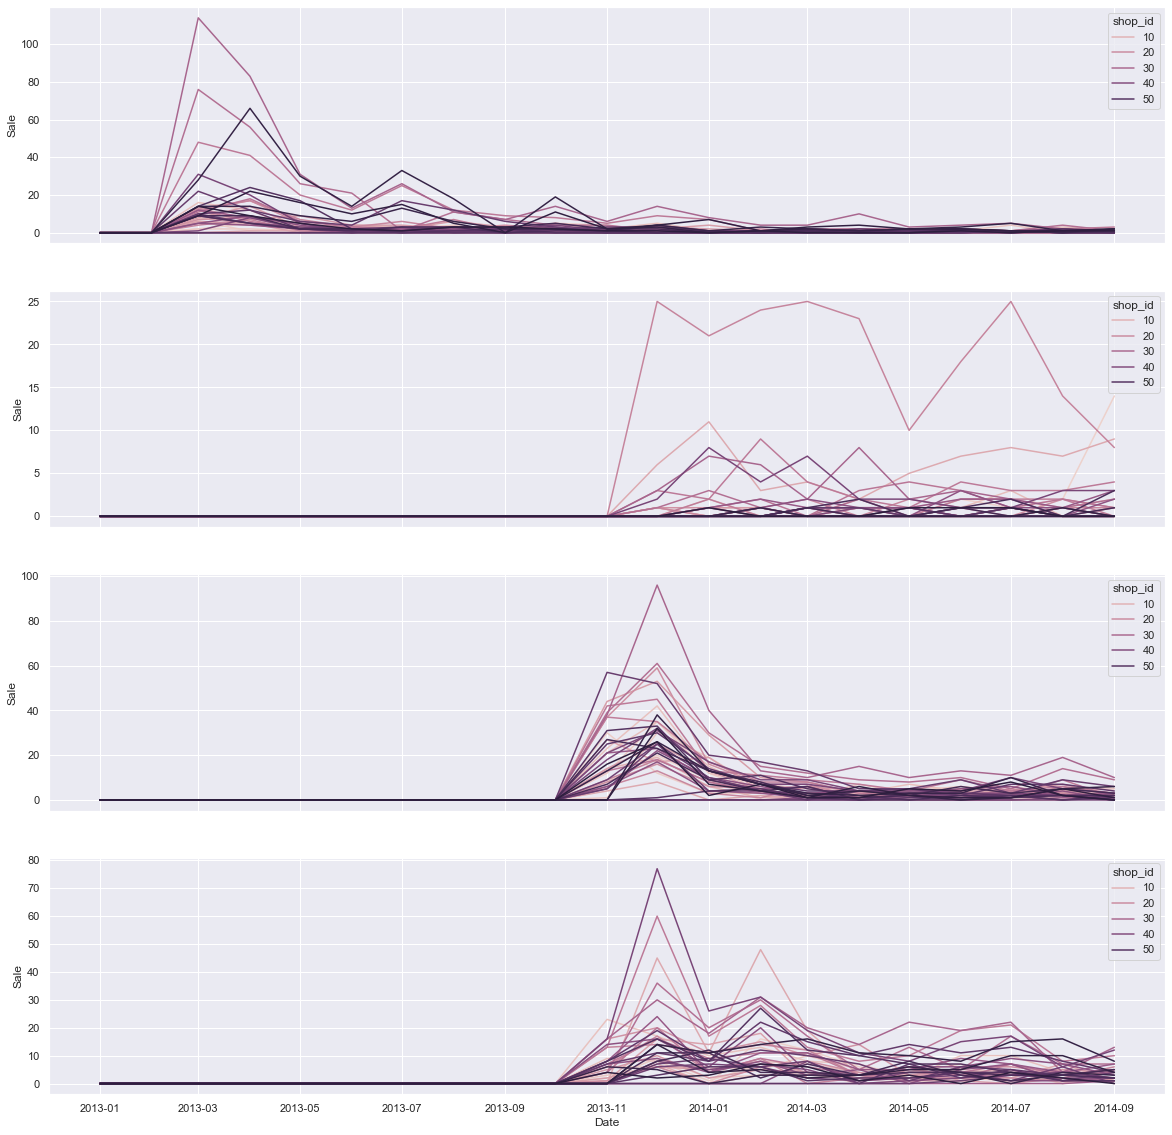

In [20]:
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(20,20), sharex=True)
ax = sns.lineplot(ax = axs[0] , data = lag_train[(lag_train.item_id == 21440) & (lag_train.InTest == 1)] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[1] , data = lag_train[(lag_train.item_id == 806) & (lag_train.InTest == 1)] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[2] , data = lag_train[(lag_train.item_id == 1495) & (lag_train.InTest == 1)] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[3] , data = lag_train[(lag_train.item_id == 5672) & (lag_train.InTest == 1)] , x="Date", y="Sale", hue = 'shop_id' )

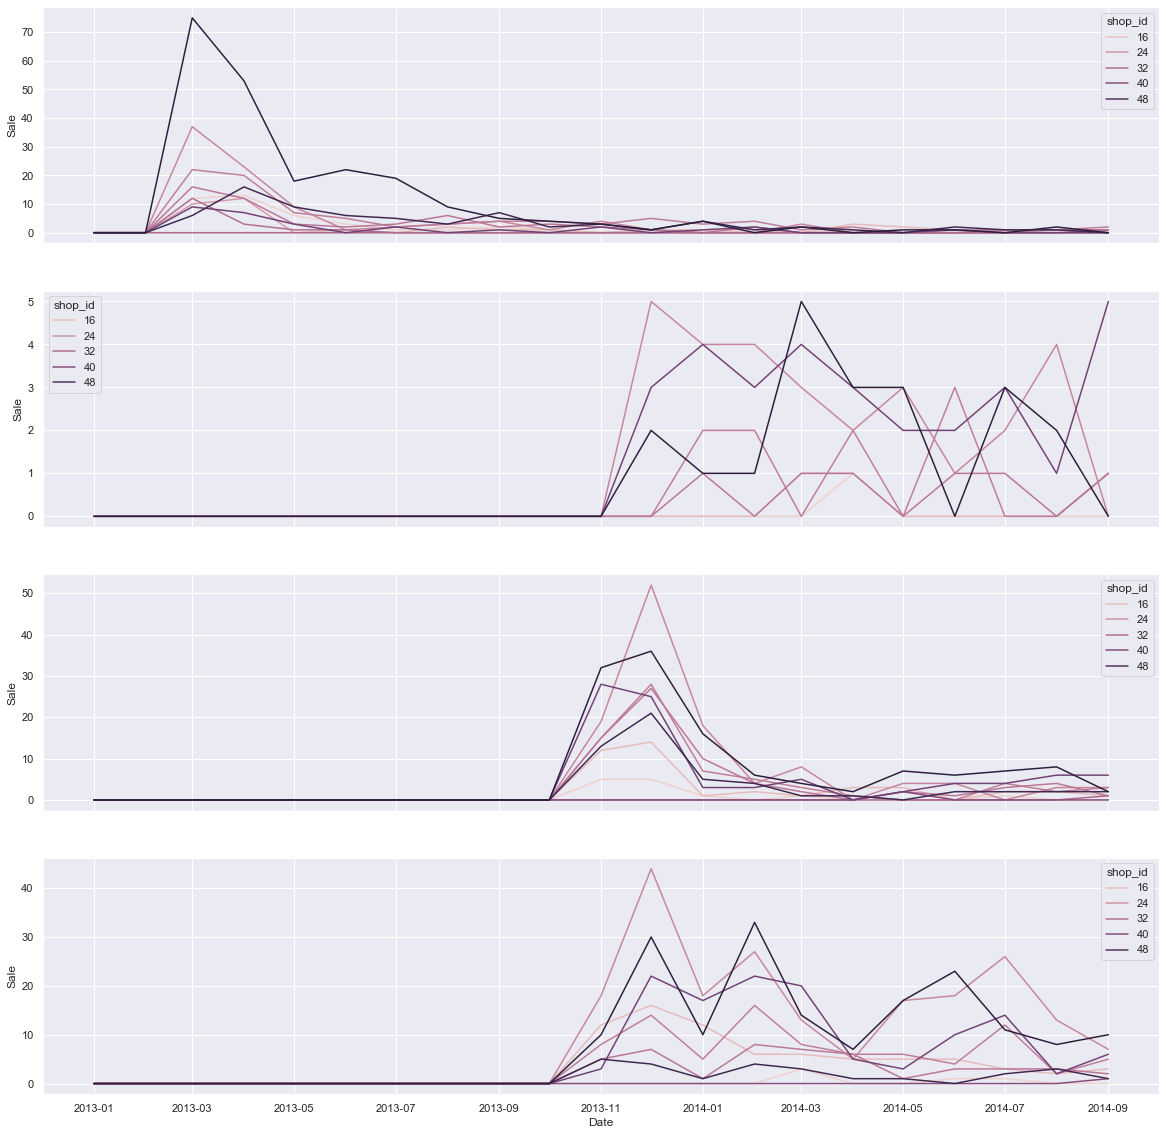

In [21]:
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(20,20), sharex=True)
ax = sns.lineplot(ax = axs[0] , data = lag_train[(lag_train.item_id == 21440) & (lag_train.InTest == 0)] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[1] , data = lag_train[(lag_train.item_id == 806) & (lag_train.InTest == 0)] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[2] , data = lag_train[(lag_train.item_id == 1495) & (lag_train.InTest == 0)] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[3] , data = lag_train[(lag_train.item_id == 5672) & (lag_train.InTest == 0)] , x="Date", y="Sale", hue = 'shop_id' )

In [22]:
lag_train.pivot_table(index= 'maxSale', columns = 'InTest', values = 'shopitem', aggfunc = 'count').reset_index().sort_values('maxSale').head(10)

InTest,maxSale,0,1
0,0.0,4746.0,525.0
1,1.0,3662400.0,547554.0
2,2.0,1014552.0,261135.0
3,3.0,392217.0,112875.0
4,4.0,203511.0,63315.0
5,5.0,126336.0,41139.0
6,6.0,83349.0,30324.0
7,7.0,60375.0,21378.0
8,8.0,45738.0,17409.0
9,9.0,32382.0,12180.0


<b> Sampling

In [23]:
def silver_sample(data,limit = 4, sample_test = 0.8,sample_noTest = 0.3):
    base_df = data[(data.maxSale < limit) ].copy()
    ids1 = list(base_df[base_df.InTest == 1].shopitem.unique())
    random.shuffle(ids1)
    ids2 = list(base_df[base_df.InTest == 0].shopitem.unique())
    random.shuffle(ids2)
    
    sel1,sel2 = int(round(len(ids1)*sample_test,0)) , int(round(len(ids2)*sample_noTest,0))
    
    ids1_sel,ids2_sel = ids1[0:sel1], ids2[0:sel2]
    
    df1 = base_df[(base_df.InTest == 1) & base_df.shopitem.isin(ids1_sel)]
    df2 = base_df[(base_df.InTest == 0) & base_df.shopitem.isin(ids2_sel)]
    df_result = pd.concat([df1,df2])
    return df_result

In [24]:
sample_train = silver_sample(poss_train, limit = 4, sample_test = 0.8,sample_noTest = 0.3)

In [25]:
sample_train.shape, poss_train.shape

((2259831, 11), (7034391, 11))

In [26]:
lag_train = sample_train.copy()
lag_train['SaleL1M'] = lag_train.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
lag_train = lag_train.assign(L0M_L1M = lag_train.Sale - lag_train.SaleL1M)

lag_train['maxVar'] = lag_train.groupby(['shopitem']).L0M_L1M.transform('max')
lag_train['minVar'] = lag_train.groupby(['shopitem']).L0M_L1M.transform('min')

lag_train = lag_train.assign( noVar = np.where(lag_train.L0M_L1M == 0, 1, 0) )
lag_train['countNoVar'] = lag_train.groupby(['shopitem']).noVar.transform('sum')
lag_train['countPoss'] = lag_train.groupby(['shopitem']).poss.transform('sum')
lag_train['month'] = lag_train.Date.dt.month
lag_train['year'] = lag_train.Date.dt.year

lag_train = lag_train.sort_values(['shopitem','Date'])

In [27]:
lag_train.head()

,InTest,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order,MiguelId,poss,maxSale,SaleL1M,L0M_L1M,maxVar,minVar,noVar,countNoVar,countPoss,month,year
1455,0,0,10038,0-10038,40,2013-01-01,0.0,1,0-10038-2013-01-01,0,1.0,NaN,NaN,1.0,-1.0,0,18,1,1,2013
336426,0,0,10038,0-10038,40,2013-02-01,1.0,2,0-10038-2013-02-01,1,1.0,0.0,1.0,1.0,-1.0,0,18,1,2,2013
671397,0,0,10038,0-10038,40,2013-03-01,0.0,3,0-10038-2013-03-01,0,1.0,1.0,-1.0,1.0,-1.0,0,18,1,3,2013
1006368,0,0,10038,0-10038,40,2013-04-01,0.0,4,0-10038-2013-04-01,0,1.0,0.0,0.0,1.0,-1.0,1,18,1,4,2013
1341339,0,0,10038,0-10038,40,2013-05-01,0.0,5,0-10038-2013-05-01,0,1.0,0.0,0.0,1.0,-1.0,1,18,1,5,2013


In [28]:
lag_train.pivot_table(index = 'countPoss',columns = 'maxSale', aggfunc ='count', values = 'shopitem')

maxSale,0.0,1.0,2.0,3.0
countPoss,,,,
0,1554.0,NaN,NaN,NaN
1,NaN,816690.0,71001.0,18018.0
2,NaN,357189.0,94563.0,29841.0
3,NaN,175371.0,83349.0,26565.0
4,NaN,88326.0,67683.0,24717.0
5,NaN,47355.0,54831.0,22554.0
6,NaN,24528.0,42630.0,17157.0
7,NaN,12285.0,31479.0,15603.0
8,NaN,6909.0,23352.0,13188.0


In [29]:
lag_train[(lag_train.countPoss == 1) & (lag_train.maxSale == 1)].item_id.unique()

array([10038, 10080, 10081, ...,  4482,  5613,  5872], dtype=int64)

testing with max sale 1 and count poss 1

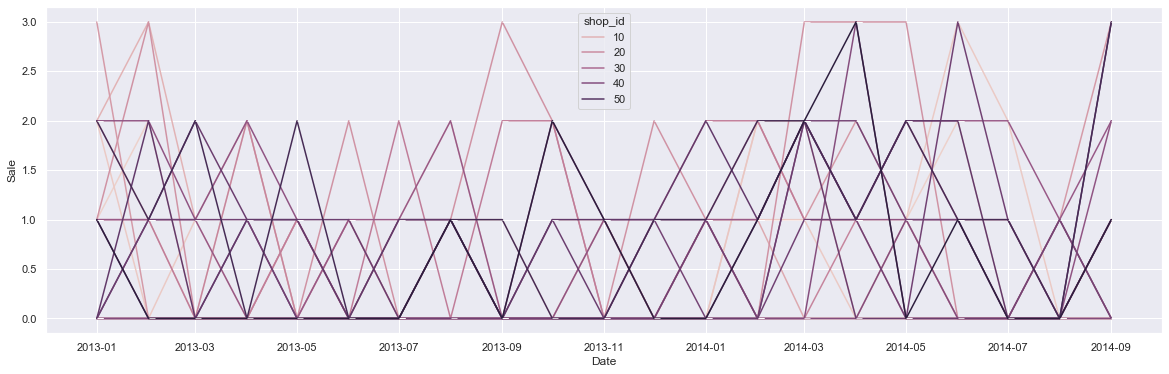

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,6), sharex=True)
ax = sns.lineplot(ax = axs , data = lag_train[(lag_train.item_id == 3554)] , x="Date", y="Sale" , hue = 'shop_id', marker = True)

In [31]:
explor = lag_train[((lag_train.countPoss >= 3) & (lag_train.countPoss <= 10)) ].copy()
explor['countShops'] = explor.groupby(['item_id']).shop_id.transform("nunique")
#explor['monthCap'] = np.where(explor.Sale == 1,explor.month,0)
#explor['monthCap'] = explor.groupby(['shopitem']).monthCap.transform('max')

In [32]:
explor.shape

(827799, 21)

In [33]:
pivot_explor = explor.pivot_table(index = ['item_category_id','item_id','countShops'], columns = ['year','month'], values = 'Sale', aggfunc = 'sum')\
    .reset_index()\
    .sort_values(['item_category_id','item_id'])\

In [34]:
pivot_explor.head(5)

year  item_category_id item_id countShops  2013                              \
month                                         1     2     3     4    5    6   
0                    2    5571          9   0.0   3.0   1.0   1.0  7.0  2.0   
1                    2    5572          9   8.0   5.0   9.0   7.0  6.0  2.0   
2                    2    5573          5   3.0   0.0   1.0   4.0  3.0  2.0   
3                    2    5574          8   9.0  11.0   7.0   9.0  3.0  6.0   
4                    2    5575          9  11.0  11.0  10.0  13.0  5.0  5.0   

year         ...      2014                                          
month     7  ...   12    1    2    3    4    5    6    7    8    9  
0       6.0  ...  2.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  
1      10.0  ...  8.0  6.0  3.0  3.0  4.0  1.0  2.0  4.0  1.0  2.0  
2       1.0  ...  3.0  6.0  1.0  3.0  1.0  0.0  0.0  0.0  0.0  1.0  
3       7.0  ...  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4       3.0  ...  3.0  2.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 24 columns]

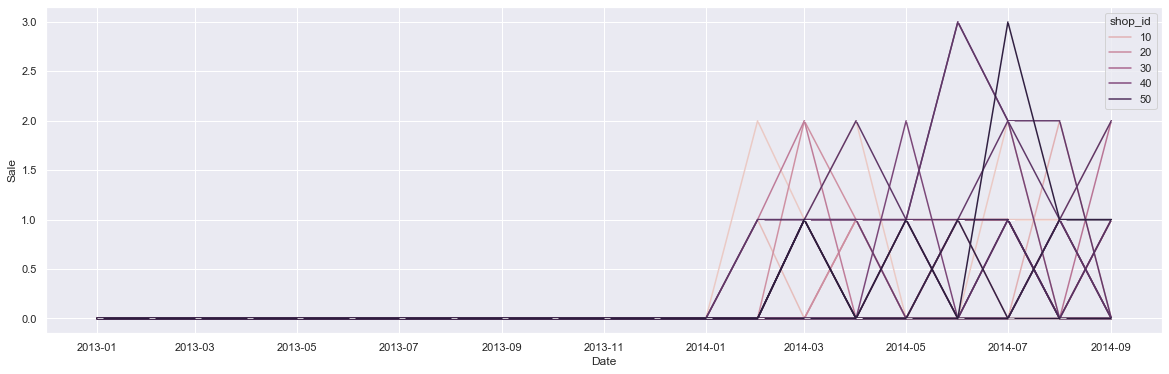

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,6), sharex=True)
ax = sns.lineplot(ax = axs , data = lag_train[(lag_train.item_id == 5634)] , x="Date", y="Sale" , hue = 'shop_id', marker = True)

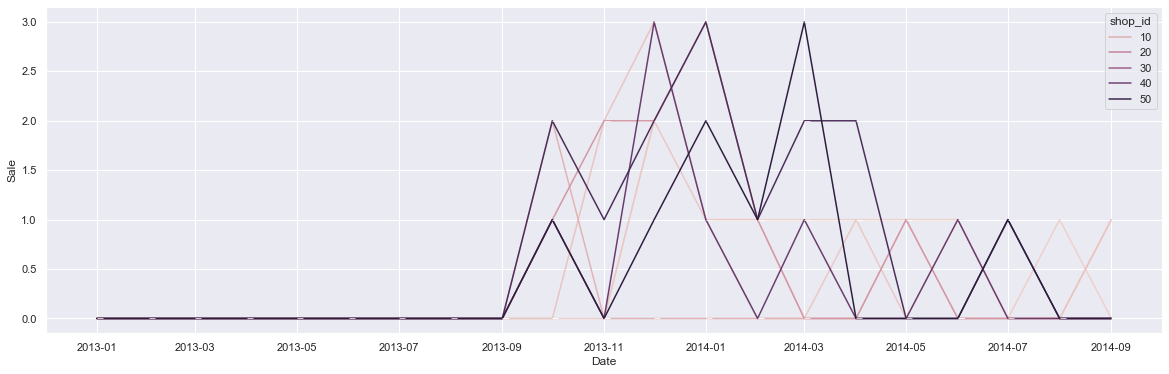

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,6), sharex=True)
ax = sns.lineplot(ax = axs , data = lag_train[(lag_train.item_id == 13516)] , x="Date", y="Sale" , hue = 'shop_id', marker = True)

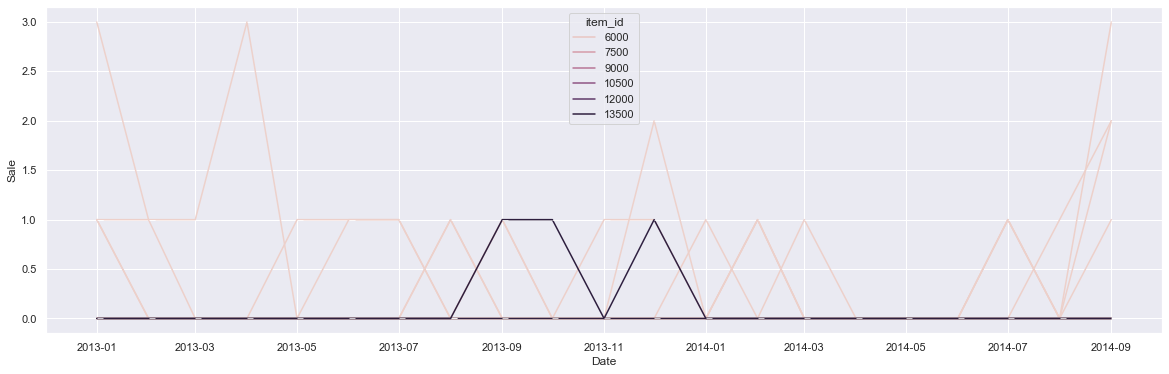

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,6), sharex=True)
ax = sns.lineplot(ax = axs , data = lag_train[((lag_train.item_category_id == 2) & (lag_train.shop_id == 3))] , x="Date", y="Sale" , hue = 'item_id', marker = True)

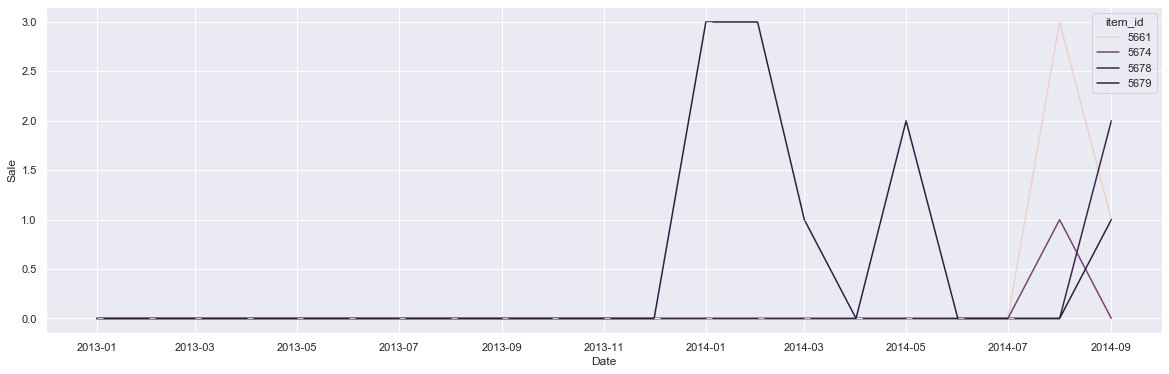

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,6), sharex=True)
ax = sns.lineplot(ax = axs , data = lag_train[((lag_train.item_category_id == 3) & (lag_train.shop_id == 25))] , x="Date", y="Sale" , hue = 'item_id', marker = True)

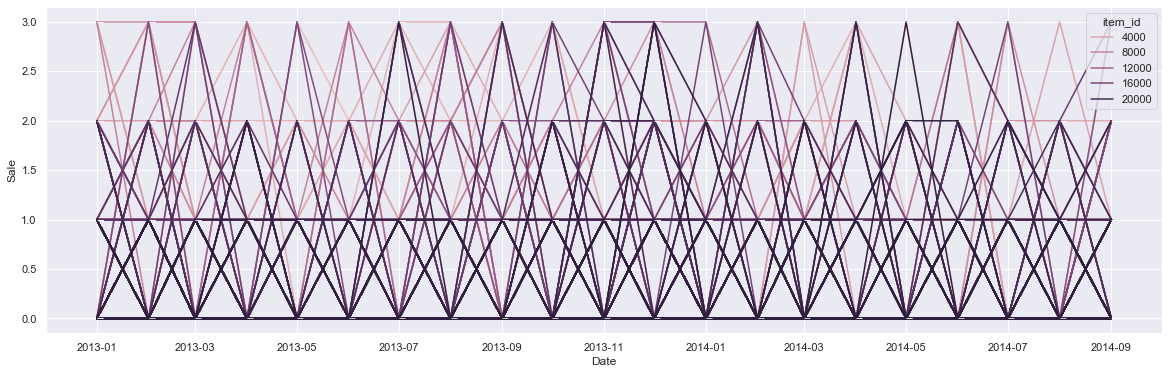

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,6), sharex=True)
ax = sns.lineplot(ax = axs , data = lag_train[((lag_train.shop_id == 10) )] , x="Date", y="Sale" , hue = 'item_id', marker = True)

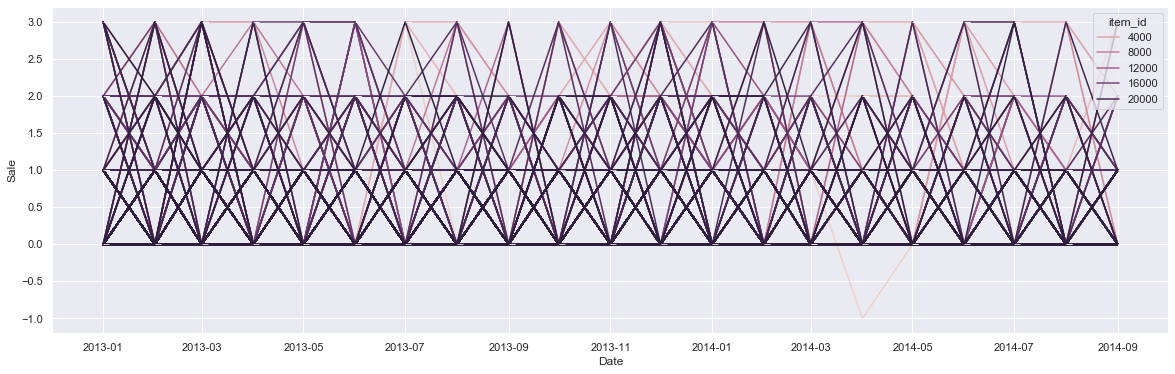

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,6), sharex=True)
ax = sns.lineplot(ax = axs , data = lag_train[((lag_train.shop_id == 30) )] , x="Date", y="Sale" , hue = 'item_id', marker = True)

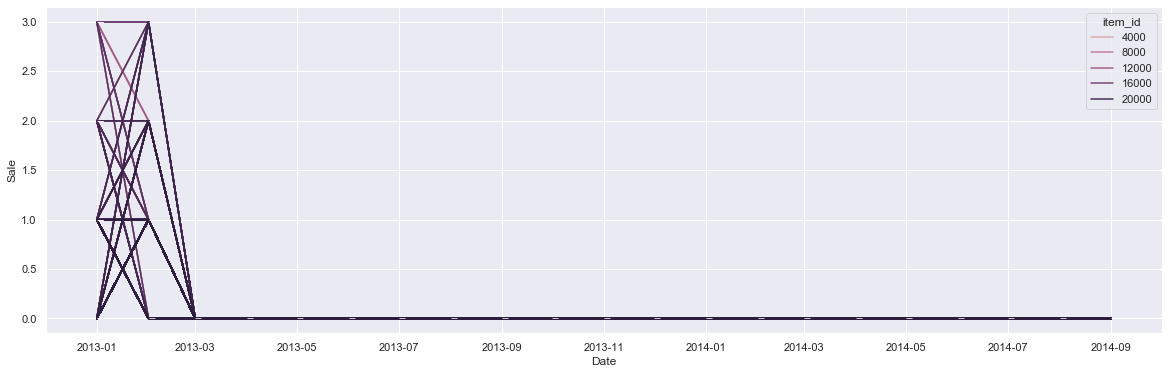

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,6), sharex=True)
ax = sns.lineplot(ax = axs , data = lag_train[((lag_train.shop_id == 1) )] , x="Date", y="Sale" , hue = 'item_id', marker = True)

In [58]:
pd.set_option('display.max_colwidth', None)
lag_train.groupby('shop_id').agg({'item_id': lambda x: tuple(set(x))} ).head()

,item_id
shop_id,
0,"(16385, 4099, 6148, 18439, 12297, 4110, 18447, 16405, 16406, 14363, 18460, 4124, 16416, 16432, 16433, 49, 51, 14389, 16439, 16441, 20541, 61, 14399, 18495, 2117, 12360, 8266, 2123, 16460, 6220, 18510, 75, 10323, 10326, 10330, 14428, 18525, 10334, 12383, 14432, 18527, 18528, 8289, 10340, 2149, 12390, 10343, 2151, 8290, 97, 4092, 18544, 14449, 18545, 115, 18548, 14453, 18550, 20592, 2163, 4211, 8313, 16507, 18557, 8317, 6272, 16515, 2179, 4229, 14470, 8334, 14479, 12434, 18580, 149, 2198, 4245, 152, 153, 18587, 8347, 14497, 12457, 12462, 10415, 12463, 18606, 16562, 18608, 10426, 14523, 14524, 20671, 16577, 14531, 18630, 18631, 12492, 16588, 12495, ...)"
1,"(16385, 18434, 18437, 2055, 6156, 27, 18462, 16416, 33, 35, 12327, 12330, 2090, 16429, 14387, 2099, 4147, 18495, 14408, 8267, 16461, 10324, 14428, 10334, 12383, 6240, 8290, 12387, 10340, 12389, 18534, 10343, 14439, 18537, 18539, 14449, 16497, 18545, 18546, 2163, 10358, 8311, 14456, 8312, 16507, 12415, 8319, 10373, 8329, 10394, 18586, 12444, 14492, 18587, 10401, 12450, 18599, 14504, 18602, 18604, 10413, 12461, 18607, 10417, 14515, 18612, 8372, 14518, 18616, 10426, 4282, 18631, 2252, 4300, 6351, 10451, 16596, 18643, 14561, 16610, 12520, 16620, 12548, 12551, 16648, 18696, 6412, 10510, 2321, 16658, 4372, 12566, 16666, 14620, 18716, 10526, 14627, 2343, 12588, 2349, ...)"
2,"(6144, 16385, 2050, 18443, 4107, 16397, 6156, 2072, 18460, 10270, 30, 32, 33, 12322, 6177, 20517, 20518, 6185, 14389, 10297, 16441, 16445, 16447, 16450, 16451, 12359, 12360, 16455, 20554, 16459, 14412, 8264, 6232, 4186, 10331, 14428, 8284, 14430, 6238, 2144, 97, 10343, 14441, 18539, 10348, 12397, 12398, 14449, 10361, 20605, 20607, 10368, 20608, 20609, 10376, 20617, 10378, 16527, 4240, 10385, 16532, 4245, 10391, 16535, 18586, 4252, 12445, 18590, 18591, 14497, 10404, 14500, 20646, 12455, 20647, 8361, 16555, 16556, 20651, 20652, 20656, 4277, 6326, 10423, 20663, 8379, 6332, 4285, 18622, 18623, 18624, 20671, 20672, 6333, 8388, 16582, 16585, 2252, 2254, 16591, ...)"
3,"(16410, 32, 33, 16422, 8235, 8248, 16447, 16449, 16453, 16459, 76, 78, 8283, 16501, 16502, 16503, 16515, 16519, 8330, 8331, 16526, 16528, 16531, 16533, 16534, 16535, 16538, 16546, 16548, 8378, 16582, 16587, 8395, 16591, 8400, 8401, 16598, 16603, 16604, 8416, 16621, 16624, 16626, 8436, 8450, 8452, 16647, 8455, 16662, 16676, 8505, 8528, 16728, 16729, 16730, 8536, 16732, 16733, 16735, 8577, 16789, 16792, 16793, 8624, 8635, 8647, 8656, 471, 8666, 8668, 481, 482, 484, 16873, 16875, 491, 8685, 8687, 496, 8690, 16888, 16889, 8705, 16899, 16901, 8716, 534, 8728, 16921, 8743, 16937, 553, 8754, 16954, 8764, 16958, 8766, 8769, 8778, 8779, ...)"
4,"(16385, 8193, 16404, 16409, 28, 33, 16424, 16431, 48, 8242, 51, 16441, 59, 8256, 16451, 16456, 72, 16459, 76, 16461, 16470, 88, 8282, 91, 94, 16481, 98, 8291, 8292, 16492, 109, 115, 8308, 8313, 16507, 8322, 8324, 8325, 8331, 16524, 8333, 8338, 16534, 16536, 8345, 154, 8346, 16544, 8357, 16550, 16555, 16556, 16557, 8363, 16560, 16567, 8384, 16582, 16583, 16585, 8396, 16593, 8401, 16599, 16603, 8415, 8416, 8419, 8426, 16624, 8432, 8436, 16638, 16641, 8452, 16657, 16662, 16664, 16665, 16668, 16670, 16676, 8508, 8509, 16735, 8556, 8571, 8577, 8591, 8597, 8598, 8602, 8606, 421, 8618, 8624, 8633, 8643, 8647, 8648, ...)"


some points:
* the last, two first and first parts of the item id seems to give some information
* there are coincidences using the first two digits % 4

In [68]:
df_explo = lag_train.assign(digits = lag_train.item_id.astype('str').str.strip().str[0:2]).copy()
df_explo['residual'] = df_explo.digits.astype('int')%4
df_explo[df_explo.residual != 0].groupby('shop_id').agg({'item_id': lambda x: tuple(set(x))} ).head(5)

,item_id
shop_id,
0,"(6148, 18439, 4110, 18447, 14363, 18460, 4124, 49, 51, 14389, 61, 14399, 18495, 2117, 8266, 2123, 6220, 75, 18510, 10323, 10326, 10330, 14428, 18525, 10334, 18527, 14432, 18528, 8289, 8290, 10340, 2149, 97, 10343, 2151, 18544, 14449, 18545, 115, 18548, 14453, 18550, 2163, 4211, 8313, 18557, 8317, 6272, 2179, 4229, 14470, 8334, 14479, 18580, 149, 2198, 4245, 152, 153, 18587, 8347, 14497, 18606, 10415, 18608, 10426, 14523, 14524, 14531, 18630, 18631, 10450, 2258, 14548, 4307, 10459, 18655, 18656, 18657, 10466, 4323, 4325, 4327, 18664, 14569, 18666, 4328, 18674, 14582, 14584, 10492, 6397, 2302, 18690, 14595, 10506, 14604, 10510, 18717, 10526, ...)"
1,"(18434, 18437, 6156, 27, 18462, 33, 35, 14387, 4147, 18495, 14408, 8267, 10324, 14428, 10334, 6240, 8290, 10340, 18534, 10343, 14439, 18537, 18539, 14449, 18545, 18546, 2163, 10358, 8311, 14456, 8312, 8319, 10373, 8329, 10394, 18586, 14492, 18587, 10401, 18599, 14504, 18602, 18604, 10413, 18607, 10417, 14515, 18612, 8372, 14518, 18616, 10426, 4282, 18631, 2252, 4300, 6351, 10451, 18643, 14561, 18696, 10510, 2321, 4372, 14620, 18716, 10526, 14627, 2343, 2349, 10545, 14646, 18749, 14665, 14667, 14668, 14678, 18783, 18805, 10620, 10621, 10626, 18826, 10641, 8597, 18842, 18857, 8620, 10674, 6579, 4532, 8628, 14776, 10686, 14782, 14791, 4551, 6599, 6604, 14798, ...)"
2,"(6144, 18443, 4107, 6156, 18460, 10270, 30, 33, 6177, 6185, 14389, 10297, 8264, 14412, 6232, 4186, 10331, 14428, 8284, 14430, 6238, 2144, 97, 10343, 14441, 18539, 10348, 14449, 10361, 10368, 10376, 10378, 4240, 10385, 4245, 10391, 18586, 4252, 18590, 18591, 14497, 10404, 14500, 8361, 4277, 6326, 10423, 8379, 6332, 4285, 18622, 18623, 18624, 6333, 8388, 2252, 2254, 6352, 2258, 10452, 6357, 14550, 10455, 10456, 10457, 14551, 2274, 18660, 2281, 6378, 18669, 4333, 10480, 6386, 14580, 4350, 2303, 4352, 2307, 10500, 14596, 4359, 4361, 2318, 10511, 4366, 4368, 4371, 4374, 4377, 4378, 18715, 10526, 14624, 2340, 2342, 4391, 2345, 2346, 4393, ...)"
3,"(18436, 4100, 18439, 4107, 6156, 18451, 18452, 4118, 4124, 18462, 33, 14374, 6183, 18472, 8235, 18476, 18481, 10290, 18484, 10293, 14389, 14390, 6200, 8248, 6202, 18491, 10300, 18492, 9780, 18498, 4163, 9784, 14412, 78, 18511, 6229, 14423, 4186, 10331, 2140, 14429, 10334, 14430, 6237, 10337, 14433, 14434, 10340, 14436, 10343, 6247, 10347, 10348, 14443, 14447, 10352, 18544, 18546, 2163, 18549, 18555, 6270, 4228, 14470, 2182, 10378, 8330, 8331, 6285, 6286, 4240, 10385, 4242, 2196, 4244, 4245, 10391, 4247, 6136, 18586, 4251, 4252, 10405, 4262, 18603, 18604, 18605, 4267, 2223, 18617, 4282, 8378, 6332, 4285, 6333, 2244, 10437, 6342, 18631, 4296, ...)"
4,"(8193, 33, 8242, 51, 59, 8256, 8282, 91, 94, 98, 8291, 8292, 109, 115, 8308, 8313, 8322, 8324, 8325, 8331, 8333, 8338, 8345, 154, 8346, 8357, 8363, 8384, 8396, 8508, 8509, 8556, 8571, 8577, 8591, 8597, 8598, 8602, 8606, 421, 8618, 8624, 8633, 8643, 8647, 8648, 464, 8656, 8661, 472, 8664, 8666, 8675, 491, 8684, 8685, 8690, 8707, 8711, 8715, 8716, 8727, 8729, 8743, 554, 555, 8756, 8758, 8766, 8769, 8770, 8778, 8787, 8788, 8794, 8798, 17009, 17010, 17017, 17027, 17042, 17049, 17052, 17063, 17066, 17067, 17072, 17076, 699, 701, 17096, 8907, 716, 17101, 8918, 17113, 8929, 17127, 8936, 8942, ...)"


In [74]:
lag_train.pivot_table(index = 'shop_id', values = 'Sale', aggfunc = 'sum', columns = 'Order')

Order,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
shop_id,,,,,,,,,,,,,,,,,,,,,
0,799.0,797.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,469.0,607.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,299.0,137.0,166.0,132.0,128.0,180.0,194.0,178.0,143.0,122.0,...,247.0,181.0,162.0,188.0,182.0,178.0,176.0,169.0,198.0,180.0
3,234.0,226.0,240.0,193.0,185.0,207.0,175.0,251.0,215.0,169.0,...,293.0,277.0,232.0,260.0,228.0,212.0,241.0,219.0,260.0,218.0
4,435.0,434.0,357.0,55.0,251.0,244.0,324.0,379.0,254.0,265.0,...,426.0,315.0,254.0,303.0,282.0,267.0,290.0,273.0,337.0,273.0
5,0.0,232.0,288.0,262.0,264.0,274.0,270.0,320.0,240.0,288.0,...,404.0,378.0,270.0,373.0,279.0,294.0,326.0,349.0,400.0,328.0
6,749.0,692.0,719.0,553.0,532.0,647.0,640.0,599.0,553.0,566.0,...,873.0,569.0,524.0,464.0,486.0,472.0,504.0,512.0,553.0,501.0
7,491.0,464.0,403.0,322.0,325.0,351.0,413.0,435.0,376.0,315.0,...,497.0,409.0,419.0,364.0,292.0,330.0,415.0,381.0,447.0,343.0
8,347.0,256.0,201.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<b> feature definition

In [78]:
myfeature_shop = train_full.assign( poss = np.where(train_full.Sale > 0, 1, 0) ).copy()
myfeature_shop['maxSale'] = myfeature_shop.groupby(['shopitem']).Sale.transform(lambda x: x.max())

myfeature_shop = silver_sample(myfeature_shop, limit = 4, sample_test = 0.8,sample_noTest = 0.3)

myfeature_shop['SaleL1M'] = myfeature_shop.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
myfeature_shop = myfeature_shop.assign(L0M_L1M = myfeature_shop.Sale - myfeature_shop.SaleL1M)

myfeature_shop['maxVar'] = myfeature_shop.groupby(['shopitem']).L0M_L1M.transform('max')
myfeature_shop['minVar'] = myfeature_shop.groupby(['shopitem']).L0M_L1M.transform('min')

myfeature_shop = myfeature_shop.assign( noVar = np.where(myfeature_shop.L0M_L1M == 0, 1, 0) )
myfeature_shop['countNoVar'] = myfeature_shop.groupby(['shopitem']).noVar.transform('sum')
myfeature_shop['countPoss'] = myfeature_shop.groupby(['shopitem']).poss.transform('sum')
myfeature_shop['month'] = myfeature_shop.Date.dt.month
myfeature_shop['year'] = myfeature_shop.Date.dt.year

myfeature_shop = myfeature_shop.sort_values(['shopitem','Date'])

In [80]:
myfeature_shop.pivot_table(index = 'countPoss',columns = 'maxSale', aggfunc ='count', values = 'shopitem').head()

maxSale,0.0,1.0,2.0,3.0
countPoss,,,,
0,1848.0,NaN,NaN,NaN
1,NaN,819903.0,71820.0,17724.0
2,NaN,356454.0,93555.0,27447.0
3,NaN,173985.0,83664.0,26838.0
4,NaN,89439.0,69636.0,24129.0


In [81]:
myfeature_shop.pivot_table(index = ['shop_id','month'],values = 'L0M_L1M', aggfunc = 'max').reset_index().head()

,shop_id,month,L0M_L1M
0,0,1,0.0
1,0,2,3.0
2,0,3,0.0
3,0,4,0.0
4,0,5,0.0


In [84]:
myfeature_shop[myfeature_shop.poss < 5].pivot_table(index = ['item_id','month'],values = 'L0M_L1M', aggfunc = 'mean').reset_index().head()

,item_id,month,L0M_L1M
0,1,1,0.0
1,1,2,0.0
2,1,3,0.0
3,1,4,1.0
4,1,5,-1.0
